In [70]:
import cv2
import numpy as np
import torch
import pathlib
from ultralytics import YOLO
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt

from typing import List, Dict, Tuple

# model = YOLO('/home/mfclabber/yandex_camp_software/src/weights/red_boxes_detection.pt')

# cap = cv2.VideoCapture(0)
# if not cap.isOpened():
#     print("Не удалось открыть камеру")
#     exit()

# while True:
#     ret, frame = cap.read()
#     if not ret:
#         print("Не удалось получить кадр")
#         break

#     results = model(frame, conf=0.5)

#     annotated_frame = results[0].plot()
#     cv2.imshow('YOLOv8 Detection', annotated_frame)

#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()

# def calculate_pnp(bboxes, object_3d_points, camera_matrix, dist_coeffs):
#     # Преобразуем координаты граничной рамки в центры
#     object_2d_points = np.array([
#         [(bboxes[0, 0] + bboxes[0, 2]) / 2, (bboxes[0, 1] + bboxes[0, 3]) / 2],  # Центр первой рамки
#         [(bboxes[1, 0] + bboxes[1, 2]) / 2, (bboxes[1, 1] + bboxes[1, 3]) / 2],  # Центр второй рамки
#         [(bboxes[2, 0] + bboxes[2, 2]) / 2, (bboxes[2, 1] + bboxes[2, 3]) / 2],  # Центр третьей рамки
#         [(bboxes[3, 0] + bboxes[3, 2]) / 2, (bboxes[3, 1] + bboxes[3, 3]) / 2]   # Центр четвертой рамки
#     ], dtype=np.float32)

#     # Применяем solvePnP для получения позиции и ориентации объекта
#     success, rvec, tvec = cv2.solvePnP(object_3d_points, object_2d_points, camera_matrix, dist_coeffs)
    
#     if success:
#         print(f"Rotation Vector (rvec): {rvec}")
#         print(f"Translation Vector (tvec): {tvec}")
#         return rvec, tvec
#     else:
#         print("solvePnP failed!")
#         return None, None

def solve_pnp_for_bbox(bbox_2d, object_points_3d, camera_matrix, dist_coeffs):
    # Центры углов bounding box'а в 2D (из YOLO)
    image_points = np.array([
        [bbox_2d[0], bbox_2d[1]],  # верхний левый угол
        [bbox_2d[2], bbox_2d[1]],  # верхний правый угол
        [bbox_2d[2], bbox_2d[3]],  # нижний правый угол
        [bbox_2d[0], bbox_2d[3]]   # нижний левый угол
    ], dtype=np.float32)

    # Применение PnP
    success, rotation_vector, translation_vector = cv2.solvePnP(object_points_3d, image_points, camera_matrix, dist_coeffs)

    if success:
        return rotation_vector, translation_vector
    else:
        print("PnP не удалось выполнить")
        return None, None


class YOLOv8n(torch.nn.Module):
    def __init__(self, path2weights: pathlib.Path, num_classes: int=4) -> None:
        super().__init__()

        self.model = YOLO(path2weights)

    def predict(self, X: np.ndarray, confidence=50) -> List[torch.Tensor]:
        results = self.model.predict(X, conf=confidence/100, verbose=False)
        bboxes = results[0].boxes.data[:, :4]
        labels = results[0].boxes.cls
        print(labels)
        scores = results[0].boxes.conf
            
        return bboxes.detach().cpu(), labels.detach().cpu(), scores.detach().cpu()
    
    
def show_image(image: np.array, 
               bboxes_: torch.Tensor, 
               labels: torch.Tensor=None, 
               scores: torch.Tensor=None,
               distances: np.ndarray=None) -> np.ndarray:
    
    COLORS = dict([
        ("red_cube", (255, 0, 0)),
        ("red_button", (255, 0, 0)),
        ("blue_button", (0, 0, 255)),
        ("green_button", (0, 255, 0)),
        ("button_box", (255, 255, 255))
    ])
    
    # ID2LABEL = dict([
    #     (2, "blue_button"),
    #     (0, "button_box"), 
    #     (3, "green_button"),
    #     (1, "red_button")
    # ])

    ID2LABEL = dict([
        (2, "blue_button"),
        (0, "red_cube"), 
        (3, "green_button"),
        (1, "red_button")
    ])

    # ['red box', 'red button', 'blue button', 'green button']
    
    image = Image.fromarray(image)
        
    for i in range(len(bboxes_)):
        bboxes = bboxes_[i].flatten()
        draw = ImageDraw.Draw(image)
    
        draw.rectangle(bboxes.numpy(), outline = COLORS[ID2LABEL[int(labels[i])]], width=2)

        if scores != None:
            draw.text((bboxes[0], bboxes[1]-25), 
                        f"{ID2LABEL[int(labels[i])]}   {scores[i]:.2f}\ndistance {distances[i]:.2f}", 
                            COLORS[ID2LABEL[int(labels[i])]])
    return np.array(image)


# camera_matrix = np.array([[600, 0, 320],   # Фокусное расстояние по X
#                               [0, 600, 240],   # Фокусное расстояние по Y
#                               [0, 0, 1]], dtype=np.float32)
    
# dist_coeffs = np.zeros((4, 1))  # Здесь предполагается отсутствие искажений

# object_points_3d = np.array([
#     [-2.5, -2.5, 0],
#     [2.5, -2.5, 0],
#     [2.5, 2.5, 0],
#     [-2.5, 2.5, 0]
# ], dtype=np.float32)

model = YOLOv8n(path2weights="/home/mfclabber/yandex_camp_software/perception/weights/main_model_weights.pt")

image = np.array(Image.open("/home/mfclabber/yandex_camp_software/data/main_train_data/train/images/frame_0238.jpg"))

bboxes, labels, scores = model.predict(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), confidence=50)

# if len(bboxes) >= 3:
#     rvec, tvec = calculate_pnp(bboxes[0][:4], object_3d_points, camera_matrix, dist_coeffs)
    
#     if rvec is not None and tvec is not None:
#         print(f"Object Position: {tvec},\nRotation: {rvec}")

# for bbox in bboxes:
#     # Применение PnP для каждого bbox
#     rotation_vector, translation_vector = solve_pnp_for_bbox(bbox, object_points_3d, camera_matrix, dist_coeffs)

#     if rotation_vector is not None and translation_vector is not None:
#         print(f"Rotation: {rotation_vector}, Translation: {translation_vector}")

# if (labels.count(2) > 0 and labels.count(3) > 0):
    

print(bboxes, labels, scores, sep="\n")

# Image.fromarray(show_image(image, bboxes, labels, scores))

tensor([3., 1., 0., 2.], device='cuda:0')
tensor([[263.3509, 320.9434, 363.1685, 382.9678],
        [341.2199, 284.1458, 419.8999, 328.3925],
        [565.2002, 191.9922, 586.9037, 213.6460],
        [349.2077, 163.6209, 369.8571, 177.2162]])
tensor([3., 1., 0., 2.])
tensor([0.9864, 0.9656, 0.9467, 0.9417])


In [158]:
ID2LABEL = dict([
        (2, "blue_button"),
        (0, "red_cube"), 
        (3, "green_button"),
        (1, "red_button")
    ])

camera_matrix = np.array([[446.60079798, 0., 341.79583523],
                          [0., 446.7382697, 226.97034584],
                          [0., 0., 1.]], dtype=np.float32)
    
dist_coeffs = np.array([-0.19424606, -0.15660945, -0.00413803, -0.00207618,  0.18147172])

width = 0.05
height = 0.05

object_points = np.array([
    [-width / 2, -height / 2, 0],
    [width / 2, -height / 2, 0],
    [width / 2, height / 2, 0],
    [-width / 2, height / 2, 0] 
], dtype=np.float32)

def calculate_center(bbox):
    x_min, y_min, x_max, y_max = bbox
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    return np.array([x_center, y_center], dtype=np.float32)

def get_bbox_corners(bbox):
    x_min, y_min, x_max, y_max = bbox
    corners_2d = np.array([
        [x_min, y_min],  # левый нижний угол
        [x_max, y_min],  # правый нижний угол
        [x_max, y_max],  # правый верхний угол
        [x_min, y_max]   # левый верхний угол
    ], dtype=np.float32)
    return corners_2d

distances = list()
for bbox, score, label in zip(bboxes, scores, labels):
    
    corners_2d = get_bbox_corners(bbox)
    success, rvec, tvec = cv2.solvePnP(object_points, corners_2d, camera_matrix, dist_coeffs)
    position_in_world = cv2.Rodrigues(rvec)[0] @ tvec
    distances.append(np.linalg.norm(tvec))


    print(f"Object: {ID2LABEL[int(label)]}, 3D frame: {position_in_world.flatten()}, Distance {distances:.2f} m")

Object: green_button, 3D frame: [  -0.027427   -0.070507     0.21988], Distance 0.23 m
Object: red_button, 3D frame: [   0.044582    -0.16334      0.2359], Distance 0.29 m
Object: red_cube, 3D frame: [     0.8791     0.19648      0.5261], Distance 1.04 m
Object: blue_button, 3D frame: [   0.076298      0.6161     0.89449], Distance 1.09 m


In [79]:
from perception import Perception

path2model_weight = pathlib.Path("/home/mfclabber/yandex_camp_software/perception/weights/main_model_weights.pt")

perception = Perception(path2weights=path2model_weight)
image, target, positions_in_world, distances = perception.process(image=np.array(Image.open("/home/mfclabber/yandex_camp_software/data/main_train_data/train/images/frame_0442.jpg")))

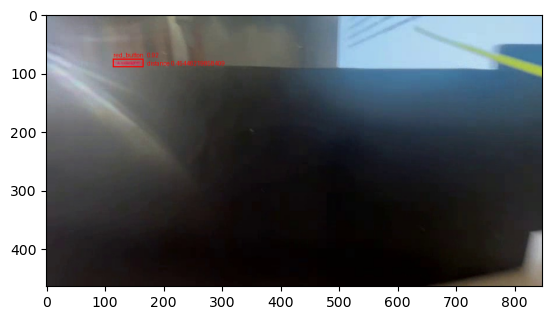

In [80]:
image1 = show_image(image, target["bboxes"], target["labels"], target["scores"], distances)
plt.imshow(image)